In [1]:
import pandas as pd
import kagglehub
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import re
from wordcloud import WordCloud
from kagglehub import KaggleDatasetAdapter
from transformers import pipeline

In [2]:
mapping = {
    # --- Data & Tech ---
    r"\bdata\s*analyst\b": "Data Analyst",
    r"\bdata\s*scientist\b": "Data Scientist",
    r"\bdata\s*engineer\b": "Data Engineer",
    r"\bmachine\s*learning\b|\bml\b": "ML Engineer",
    r"\bai\b|\bartificial intelligence\b": "AI Engineer",
    r"\bsoftware\b|\bdeveloper\b|\bprogrammer\b": "Software Engineer",
    r"\bbackend\b|\bapi\b": "Backend Developer",
    r"\bfrontend\b|\breact\b|\bangular\b|\bvue\b": "Frontend Developer",
    r"\bfull\s*stack\b": "Full Stack Developer",
    r"\bdevops\b|\bsite reliability\b": "DevOps Engineer",
    r"\bcloud\b|\baws\b|\bazure\b|\bgcp\b": "Cloud Engineer",
    r"\bqa\b|\btester\b|\btest engineer\b": "Quality Assurance",
    r"\bnetwork\b|\bsystem\b|\bit support\b": "IT Infrastructure",
    r"\bcybersecurity\b|\bsecurity analyst\b": "Cybersecurity",
    r"\bblockchain\b|\bcrypto\b": "Blockchain Engineer",
    r"\bdatabase\b|\bsql\b|\bdb administrator\b": "Database Administrator",
    r"\bgame\b|\bgaming\b|\bunity\b|\bunreal\b": "Game Developer",
    r"\bmobile\b|\bandroid\b|\bios\b|\bflutter\b": "Mobile Developer",
    r"\bui\b|\bux\b|\bdesigner\b|\bdesign(er)?\b": "UI/UX Design",
    r"\bweb\b|\bwordpress\b|\bwebmaster\b": "Web Developer",
    r"\bautomation\b|\brpa\b": "Automation Engineer",
    r"\brobotics\b": "Robotics Engineer",

    # --- Business & Management ---
    r"\bproduct\b": "Product Management",
    r"\bproject manager\b|\bpm\b": "Project Management",
    r"\bbusiness\b|\bconsultant\b": "Business Consultant",
    r"\boperations?\b|\bsupply chain\b": "Operations Management",
    r"\bstrategy\b|\bstrategic\b": "Strategy",
    r"\baccount manager\b|\bclient relationship\b": "Account Management",
    r"\bsales\b|\bsalesforce\b|\bbusiness development\b": "Sales",
    r"\bmarketing\b|\bgrowth\b|\bbrand\b|\bseo\b|\bsem\b": "Marketing",
    r"\bfinance\b|\bfinancial\b|\baccountant\b|\bauditor\b": "Finance",
    r"\bhr\b|\bhuman resources\b|\brecruiter\b|\btalent acquisition\b": "Human Resources",
    r"\blegal\b|\blawyer\b|\battorney\b": "Legal",
    r"\bcustomer service\b|\bsupport\b|\bcall center\b|\bhelpdesk\b": "Customer Service",
    r"\bsupply chain\b|\blogistics\b|\bprocurement\b": "Logistics & Supply Chain",
    r"\boperations?\s*manager\b": "Operations Manager",

    # --- Creative & Media ---
    r"\bgraphic\b|\bvisual\b|\billustrator\b": "Graphic Design",
    r"\bvideo\b|\bfilmmaker\b|\bproduction\b": "Video Production",
    r"\bphotographer\b|\bphoto\b": "Photography",
    r"\bwriter\b|\bcontent\b|\bcopy\b|\beditor\b": "Content Writing / Editing",
    r"\bmedia\b|\bcommunications?\b|\bpublic relations\b|\bpr\b": "Media & Communication",
    r"\bjournalist\b|\breporter\b": "Journalism",
    r"\btranslator\b|\blinguist\b|\blanguage\b": "Translation / Linguistics",
    r"\bart director\b|\bcreative\b": "Art & Creative Direction",

    # --- Education & Research ---
    r"\bteacher\b|\bprofessor\b|\binstructor\b|\btrainer\b|\btutor\b": "Education / Teaching",
    r"\bresearch\b|\bscientific\b|\blab\b": "Research & Development",
    r"\bpsychologist\b|\bpsychology\b": "Psychology / Mental Health",
    r"\bcoach\b|\bmentor\b": "Coaching / Mentoring",

    # --- Healthcare ---
    r"\bdoctor\b|\bphysician\b|\bmedical\b|\bsurgeon\b": "Doctor / Medical",
    r"\bnurse\b|\bhealthcare\b|\bclinic\b": "Nursing / Healthcare",
    r"\bpharma\b|\bbiotech\b|\bchemist\b": "Pharmaceutical / Biotech",
    r"\bdentist\b|\borthodontist\b": "Dentistry",
    r"\btherapist\b|\bcounselor\b": "Therapy / Counseling",

    # --- Engineering & Construction ---
    r"\bmechanical\b|\bcivil\b|\belectrical\b|\bchemical\b|\bindustrial\b": "Engineering (General)",
    r"\barchitect\b|\bconstruction\b|\bstructural\b": "Architecture / Construction",
    r"\bmaintenance\b|\btechnician\b|\boperator\b": "Maintenance / Technical",
    r"\bmanufacturing\b|\bproduction\b|\bplant\b": "Manufacturing / Production",

    # --- Miscellaneous ---
    r"\benvironment\b|\bsustainability\b|\bclimate\b": "Environmental / Sustainability",
    r"\bngo\b|\bnon[-\s]?profit\b|\bcharity\b": "Non-Profit / NGO",
    r"\breal estate\b|\brealtor\b|\bproperty\b": "Real Estate",
    r"\bsport\b|\bfitness\b|\bcoach\b|\btrainer\b": "Sports / Fitness",
    r"\bchef\b|\bkitchen\b|\brestaurant\b|\bcook\b": "Culinary / Hospitality",
    r"\btravel\b|\btourism\b|\bhotel\b|\bflight\b": "Travel & Tourism",
    r"\bartisan\b|\bcraft\b": "Artisan / Craftsmanship",
    r"\bgovernment\b|\bpublic sector\b|\bpolicy\b": "Government / Public Sector",
    r"\bmilitary\b|\bdefense\b": "Military / Defense",
    r"\breal estate\b|\bproperty\b|\bagent\b": "Real Estate",
    r"\bdriver\b|\bdelivery\b|\bcourier\b": "Transport / Delivery"
}


In [3]:
path = kagglehub.dataset_download("joykimaiyo18/linkedin-data-jobs-dataset")
df = pd.read_csv(f'{path}/clean_jobs.csv')

path = kagglehub.dataset_download("rajatraj0502/linkedin-job-2023")
df2 = pd.read_csv(f'{path}/job_postings.csv')

In [4]:
def normalize_title(title):
    title = str(title).lower()
    for pattern, category in mapping.items():
        if re.search(pattern, title):
            return category
    return "Other"

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)              
    text = re.sub(r'http\S+', '', text)           
    text = re.sub(r'<.*?>', '', text)             
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)    
    return text.strip()

In [5]:
df2.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,85008768,NaN,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
1,133114754,77766802.0,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
2,133196985,1089558.0,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,NaN,NaN,Contract,"New York, NY",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,NaN,NaN
3,381055942,96654609.0,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,NaN,NaN,NaN,NaN,Full-time,"Forney, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
4,529257371,1244539.0,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,NaN,NaN,NaN,NaN,Full-time,"New York, NY",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,NaN,NaN


In [6]:
null_info = df2.isna().mean() * 100
null_info[null_info > 0]

company_id                     2.303915
description                    0.006295
max_salary                    65.246129
med_salary                    93.824751
min_salary                    65.246129
pay_period                    59.070880
applies                       45.234798
remote_allowed                85.270049
views                         17.392673
application_url               38.341936
closed_time                   94.158378
formatted_experience_level    30.857359
skills_desc                   99.093541
posting_domain                43.069369
currency                      59.070880
compensation_type             59.070880
dtype: float64

In [7]:
df2.dropna(subset=['description'], inplace=True)
df2['description'].head()

0    While many industries were hurt by the last fe...
1    Are you a dynamic and creative marketing profe...
2    Join Us as a Model Risk Auditor – Showcase You...
3    Business ManagerFirst Baptist Church ForneyFor...
4    YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...
Name: description, dtype: object

In [8]:
df2['title'].value_counts()

title
Sales Director [Owner/Operator]                       83
Sales Associate                                       64
Retail Sales Associate                                60
Sales Director {Owner/Operator}                       54
Project Manager                                       40
                                                      ..
Greeter/Service Admin - Lexus of Greenwood Village     1
Sample Preparation Technician                          1
Procurement Administrator (Remote)                     1
Accounts Receivable Accountant                         1
Area Director of Business Development                  1
Name: count, Length: 10955, dtype: int64

In [9]:
df2['category'] = df2['title'].apply(normalize_title)
df2['text'] = df2['title'] + " " + df2['description']
df2['text'] = df2['text'].apply(clean_text)

In [10]:
print(df2.duplicated(subset='text').sum())

1823


In [11]:
df2 = df2.drop_duplicates(subset='text')

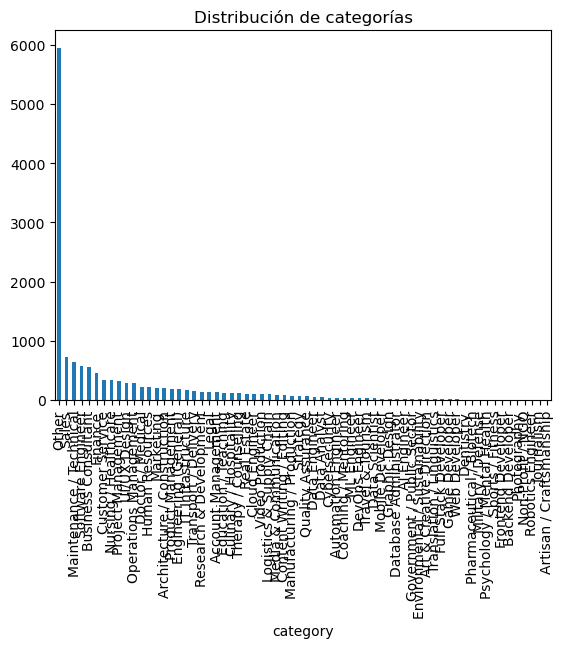

In [12]:
df2['category'].value_counts().plot(kind='bar')
plt.title('Distribución de categorías')
plt.show()

Este es el primer reto. Quizas no se  pueda manualmente segmentar los titulos; tendremos que aplicar otra tecnica.

In [13]:
df2['text_length'] = df2['text'].apply(lambda x: len(x.split()))
df2['text_length'].describe()

count    14062.000000
mean       498.669322
std        295.170738
min          2.000000
25%        278.000000
50%        457.000000
75%        673.000000
max       2806.000000
Name: text_length, dtype: float64

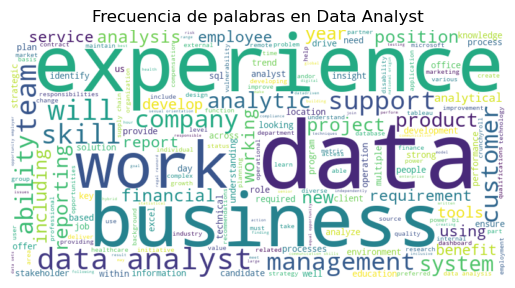

In [14]:
text = ' '.join(df2[df2['category']=='Data Analyst']['text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Frecuencia de palabras en Data Analyst")
plt.show()

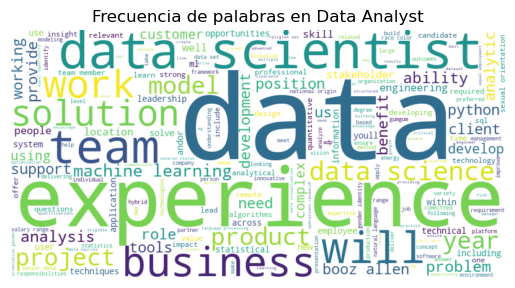

In [15]:
text = ' '.join(df2[df2['category']=='Data Scientist']['text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Frecuencia de palabras en Data Analyst")
plt.show()

In [16]:
counts = df2['category'].value_counts()
df2 = df2[df2['category'].isin(counts[counts >= 100].index)]

In [17]:
model = SentenceTransformer("all-MiniLM-L6-v2") 
embeddings2 = model.encode(df2['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/408 [00:00<?, ?it/s]

In [18]:
df2.isna().mean() * 100
df2.dropna(subset=['description'], inplace=True)

In [19]:
X = embeddings2
y = df2['category'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
clfL = LogisticRegression(max_iter=2000, class_weight='balanced')
clfL.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [21]:
y_pred2 = clfL.predict(X_test)
print(classification_report(y_test, y_pred2))

                             precision    recall  f1-score   support

         Account Management       0.39      0.92      0.55        26
Architecture / Construction       0.41      0.60      0.49        40
        Business Consultant       0.45      0.59      0.51       111
             Cloud Engineer       0.44      0.86      0.58        21
     Culinary / Hospitality       0.39      1.00      0.56        24
           Customer Service       0.42      0.70      0.53        67
           Doctor / Medical       0.34      0.80      0.48        45
       Education / Teaching       0.44      0.84      0.58        25
      Engineering (General)       0.27      0.89      0.42        36
                    Finance       0.44      0.83      0.58        90
            Human Resources       0.44      0.79      0.57        43
          IT Infrastructure       0.29      0.76      0.42        34
                      Legal       0.45      1.00      0.62        27
    Maintenance / Technical      

In [22]:
null_info = df.isna().mean() * 100
null_info[null_info > 0]

company              0.190840
location             1.431298
source               8.492366
date_posted          2.194656
work_type          100.000000
employment_type    100.000000
description          0.381679
dtype: float64

In [23]:
df.dropna(subset=['description'], inplace=True)

In [24]:
df['description'].head()

0    The Social Measurement team is a growing team ...
1    The Social Measurement team is a growing team ...
2    The Social Measurement team is a growing team ...
3    The Social Measurement team is a growing team ...
4    About Pinterest\n\nMillions of people around t...
Name: description, dtype: object

In [25]:
df['title'].value_counts()

title
Data Analyst                         152
Data Scientist                        75
Data Engineer                         58
Data Scientist, Product Analytics     29
Machine Learning Engineer             21
                                    ... 
Analyst - Data Analytics               1
Analista Cadastro II                   1
ANALISTA DE DADOS JR / PL              1
Analyst-Data Analytics                 1
Applied AI/ML - Vice President         1
Name: count, Length: 520, dtype: int64

In [26]:
df = df[~df['title'].str.contains(r'\*', na=False)]

In [27]:
df['title'].value_counts()

title
Data Analyst                                            152
Data Scientist                                           75
Data Engineer                                            58
Data Scientist, Product Analytics                        29
Machine Learning Engineer                                21
                                                       ... 
Analista de Dados Jr (área de Fraude) - São Paulo/SP      1
KX Analytics (Tableau & SQL)- Analyst-Hyderabad           1
Data Analyst Staff - Jakarta                              1
Insight Analyst UK                                        1
Applied AI/ML - Vice President                            1
Name: count, Length: 476, dtype: int64

In [28]:
df['text'] = df['title'] + " " + df['description']
df['text'] 

0       Data Analyst The Social Measurement team is a ...
1       Data Analyst The Social Measurement team is a ...
2       Data Analyst The Social Measurement team is a ...
3       Data Analyst The Social Measurement team is a ...
4       Data Analyst II About Pinterest\n\nMillions of...
                              ...                        
1043    Senior GIS/Data Management Analyst Overview:\n...
1044    Data Science Senior Associate - Card Data & An...
1045    Vice President Data Scientist Marketing Analyt...
1046    Lead Data Scientist - Finance Technology **JOB...
1047    Applied AI/ML - Vice President **JOB DESCRIPTI...
Name: text, Length: 972, dtype: object

In [29]:
df['category'] = df['title'].apply(normalize_title)

In [30]:
df['category'].value_counts()

category
Data Analyst                  276
Data Engineer                 204
Data Scientist                202
Other                         128
ML Engineer                    63
Software Engineer              22
Business Consultant            19
AI Engineer                    19
Database Administrator          5
DevOps Engineer                 5
Sales                           4
Research & Development          4
Education / Teaching            3
Cybersecurity                   3
Operations Management           2
Strategy                        2
Product Management              2
Account Management              1
Logistics & Supply Chain        1
Coaching / Mentoring            1
Media & Communication           1
Psychology / Mental Health      1
Cloud Engineer                  1
Automation Engineer             1
Content Writing / Editing       1
IT Infrastructure               1
Name: count, dtype: int64

In [31]:
print(df.duplicated(subset='text').sum())

101


In [32]:
df = df.drop_duplicates(subset='text')

In [33]:
df['text'] = df['text'].apply(clean_text)

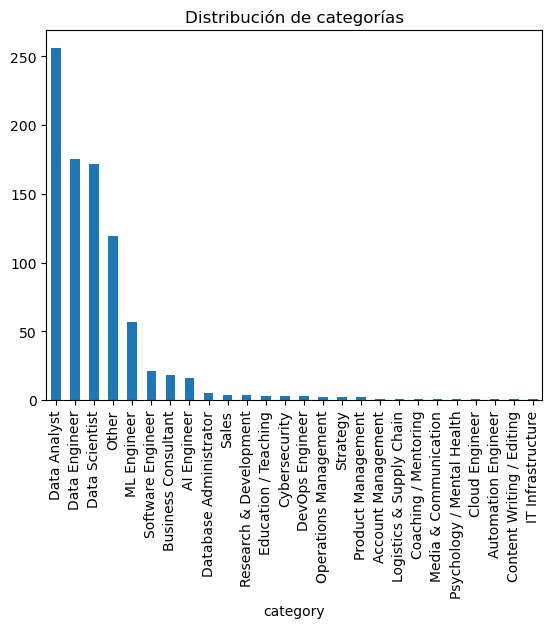

In [34]:
import matplotlib.pyplot as plt
df['category'].value_counts().plot(kind='bar')
plt.title('Distribución de categorías')
plt.show()

In [35]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df['text_length'].describe()


count     871.000000
mean      596.978186
std       290.831805
min         4.000000
25%       385.000000
50%       580.000000
75%       771.000000
max      2347.000000
Name: text_length, dtype: float64

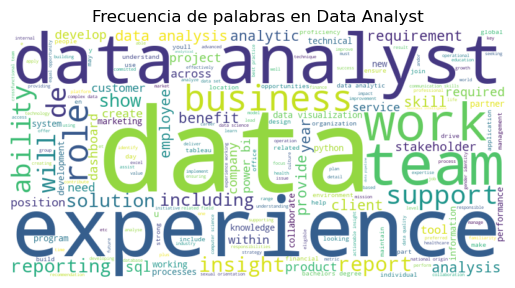

In [36]:
text = ' '.join(df[df['category']=='Data Analyst']['text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Frecuencia de palabras en Data Analyst")
plt.show()

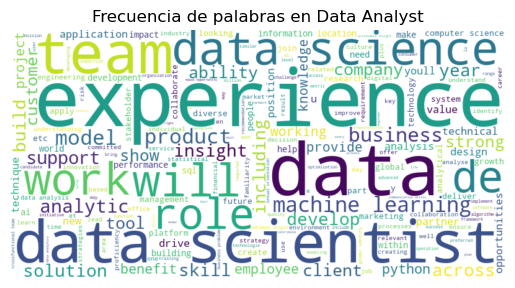

In [37]:
text = ' '.join(df[df['category']=='Data Scientist']['text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Frecuencia de palabras en Data Analyst")
plt.show()

In [38]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [39]:
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

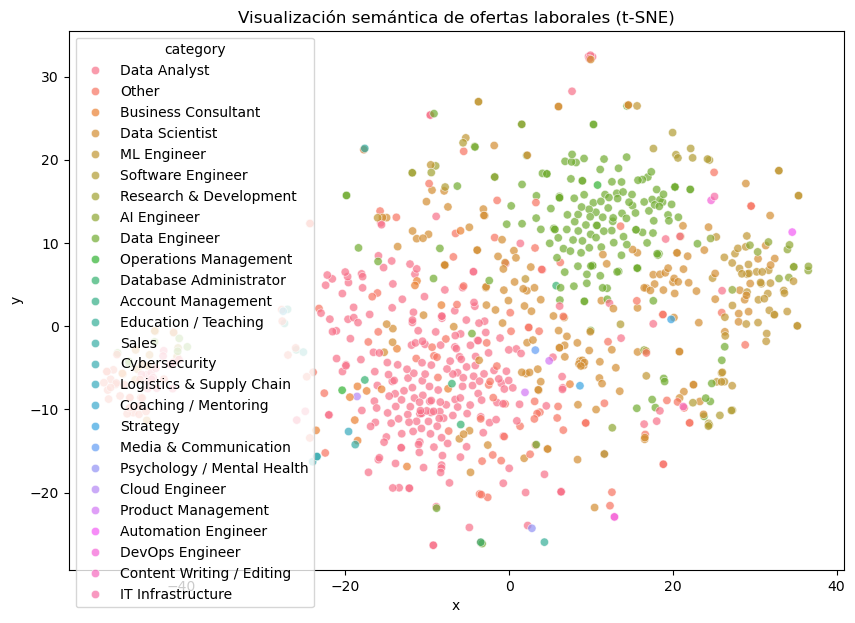

In [40]:
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_embedded = tsne.fit_transform(embeddings)

df_plot = df.copy()
df_plot['x'] = X_embedded[:,0]
df_plot['y'] = X_embedded[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(data=df_plot, x='x', y='y', hue='category', alpha=0.7)
plt.title("Visualización semántica de ofertas laborales (t-SNE)")
plt.show()


In [41]:
X = embeddings
y = df['category'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
#clf = LogisticRegression(max_iter=2000)
clfL = LogisticRegression(max_iter=2000, class_weight='balanced')
clfL.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [ ]:
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

      AI Engineer       0.00      0.00      0.00         2
         Business       0.00      0.00      0.00         3
     Data Analyst       0.71      0.98      0.83        51
    Data Engineer       0.74      0.83      0.78        35
   Data Scientist       0.78      0.71      0.75        35
      ML Engineer       0.00      0.00      0.00         2
       Operations       0.00      0.00      0.00         1
            Other       0.76      0.52      0.62        25
            Sales       0.00      0.00      0.00         1
Software Engineer       0.65      0.55      0.59        20

         accuracy                           0.73       175
        macro avg       0.37      0.36      0.36       175
     weighted avg       0.70      0.73      0.70       175



/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

In [ ]:
y_pred = clfL.predict(X_test)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

       AI Engineer       0.20      0.50      0.29         2
          Business       0.33      0.33      0.33         3
      Data Analyst       0.92      0.86      0.89        51
     Data Engineer       0.82      0.94      0.88        35
    Data Scientist       0.96      0.66      0.78        35
       ML Engineer       0.00      0.00      0.00         2
        Operations       0.00      0.00      0.00         1
             Other       0.65      0.68      0.67        25
Product Management       0.00      0.00      0.00         0
             Sales       0.50      1.00      0.67         1
 Software Engineer       0.70      0.80      0.74        20

          accuracy                           0.78       175
         macro avg       0.46      0.53      0.48       175
      weighted avg       0.81      0.78      0.78       175



/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/mathias/.conda/envs/datasci/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

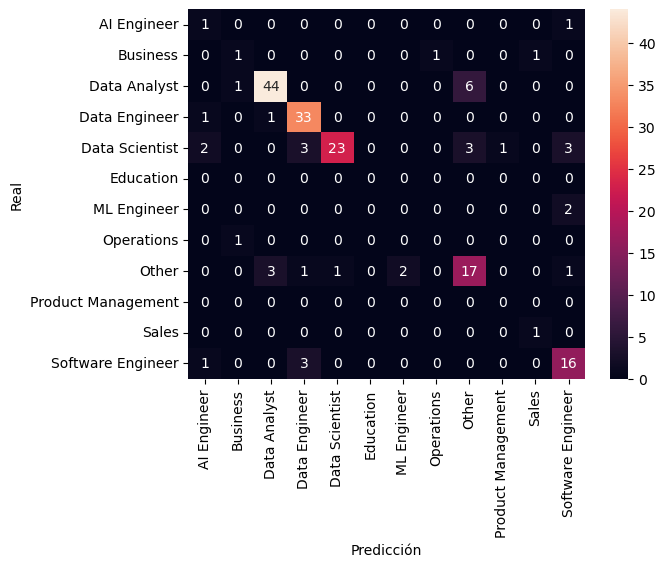

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()
